# Sentence Transformers

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_jobs = pd.read_csv('jobs.csv')
df_resume = pd.read_csv('all_resume_sections.csv')
df_resume.drop(columns=['INTERESTS', 'AWARDS'], inplace=True)
df_resume.fillna('', inplace=True)

## Preprocessing

In [3]:
import re

def clean_description(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\+]', ' ', text)
    # Remove extra blank spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text

clean_description("I have skills in developing applications using Python3, React.js, and JavaScript.      I can use Java, express.JS and NodeJS!")

'i have skills in developing applications using python react js and javascript i can use java express js and nodejs'

In [4]:
# Combine text from all columns to get overall resume text
df_resume['clean_resume_text'] = df_resume[['PROFILE', 'EXPERIENCE', 'PROJECTS', 'CERTIFICATIONS']].apply(lambda row: ' '.join(row), axis=1).apply(clean_description)
df_resume.head()[['Filename', 'clean_resume_text']]

,Filename,clean_resume_text
0,1. Front End Developer - Resume,resume worded new york ny front end developer ...
1,1. Web Developer - Resume,resume worded new york ny web developer januar...
2,2. Full Stack Web Developer - Resume,resume worded new york ny jun present full sta...
3,3. Entry Level Web Developer Resume,resume worded co employee venture backed recru...
4,4. Freelance Web Developer resume,resume worded san francisco ca and new york ny...


In [5]:
df_resume.drop(columns=['PROFILE', 'CERTIFICATIONS'], inplace=True)

# Choose target job

In [6]:
target_job = df_jobs.loc[1]

Preprocess job description  
This adds the title, and skills to the description.  
Then cleans it.

In [7]:
def preprocess_job(target_job):
    title, description, skills = (
        target_job['title'],
        target_job['description'],
        target_job['skills'],
    )    # Clean description
    if skills:
        description = skills.replace(',', '') + ' ' + description
    if title:
        description = f'{title} {description}'
    description = clean_description(description)
    # print('Cleaned job description:', description)
    return description

In [8]:
import textwrap

wrapped_content = textwrap.fill(target_job['description'], 100)
print(wrapped_content)

We are hiring a versatile Full Stack Developer to join our dynamic team. As a Full Stack Developer,
you will be responsible for developing both frontend and backend components of web applications. You
will work closely with UX/UI designers and backend engineers to deliver high-quality and user-
friendly applications. Proficiency in frontend technologies such as HTML, CSS, and JavaScript is
required, along with expertise in server-side frameworks like Node.js and Express. Experience with
databases like MongoDB and MySQL is also desirable. If you are a collaborative team player with a
passion for creating innovative software solutions, we want to hear from you!


## Tfidf
For comparing job-description and resume-description

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:

def get_description_score(target_job):
    # Initialize the TfidfVectorizer
    # min_df=3 means ignore terms that appear in less than 3 document
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)

    # fit_transform the vectorizers and create tfidf matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform([preprocess_job(target_job)] + df_resume['clean_resume_text'].values.tolist())
    
    # Calculate cosine similarity between the job description and resumes
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    df_resume['description_score'] = cosine_similarities

In [11]:
get_description_score(target_job)

# BERT

In [12]:
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

def get_sentence_transformer_model_score(target_job, model_name, model):
    print(f'\nModel={model_name} Embedding-Dimensions={model.get_sentence_embedding_dimension()}')

    job_embeddings = model.encode(preprocess_job(target_job))   
    # resume_embeddings = model.encode(df_resume['clean_resume_text'])

    resume_embeddings = np.zeros((len(df_resume), model.
    get_sentence_embedding_dimension()))
    for i in tqdm(range(len(df_resume)), desc='Encoding resume texts', unit='resumes'):
        resume_embeddings[i] = model.encode(df_resume.iloc[i]['clean_resume_text'])
    
    # Calculate cosine similarity between the job description and resumes
    cosine_similarities = cosine_similarity(resume_embeddings, [job_embeddings])

    # Set negative scores to 0
    cosine_similarities[cosine_similarities < 0] = 0

    df_resume[model_name] = cosine_similarities

## bert-base-nli-mean-tokens

In [13]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
MODEL_NAME = 'bert-base-nli-mean-tokens'
model = SentenceTransformer(MODEL_NAME)

In [14]:
get_sentence_transformer_model_score(target_job, MODEL_NAME, model)


Model=bert-base-nli-mean-tokens Embedding-Dimensions=768


Encoding resume texts: 100%|██████████| 43/43 [00:18<00:00,  2.28resumes/s]


## all-MiniLM-L12-v2 model

In [15]:
# Load a pre-trained sentence transformer model
MODEL_NAME = 'all-MiniLM-L12-v2'
model = SentenceTransformer(MODEL_NAME)

In [16]:
get_sentence_transformer_model_score(target_job, MODEL_NAME, model)


Model=all-MiniLM-L12-v2 Embedding-Dimensions=384


Encoding resume texts: 100%|██████████| 43/43 [00:07<00:00,  5.61resumes/s]


## all-MiniLM-L6-v2

In [ ]:
# Load a pre-trained sentence transformer model
MODEL_NAME = 'all-MiniLM-L6-v2'
model = SentenceTransformer(MODEL_NAME)

In [23]:
get_sentence_transformer_model_score(target_job, MODEL_NAME, model)


Model=all-MiniLM-L6-v2 Embedding-Dimensions=384


Encoding resume texts: 100%|██████████| 43/43 [00:06<00:00,  6.76resumes/s]


In [24]:
df_resume[['Filename', 'clean_resume_text', 'description_score', 'bert-base-nli-mean-tokens', 'all-MiniLM-L12-v2', 'all-MiniLM-L6-v2']].sort_values(by='bert-base-nli-mean-tokens', ascending=False)

,Filename,clean_resume_text,description_score,bert-base-nli-mean-tokens,all-MiniLM-L12-v2,all-MiniLM-L6-v2
15,jan-kusters-left-sidebar-cv,it consultant with strong theoretical skills a...,0.165178,0.861012,0.506481,0.424858
41,web-developer,junior software developer revature llc current...,0.102226,0.846060,0.463987,0.336671
8,entry-level-web-developer,donationxchange web developer intern july curr...,0.206841,0.829065,0.584910,0.506536
42,web-developer2 - Template 18,resume worded london united kingdom education ...,0.102492,0.816834,0.473159,0.373293
4,4. Freelance Web Developer resume,resume worded san francisco ca and new york ny...,0.095193,0.810691,0.488783,0.338126
19,latex0,google mountain view ca software engineer oct ...,0.058903,0.809844,0.370858,0.336562
32,res_sp,highly motivated computer engineering student ...,0.061216,0.808655,0.522847,0.466285
12,front-end-web-developer2 - Template 16,resume worded new york ny present augmented re...,0.177309,0.789020,0.498143,0.449893
6,backend-web-developer,web developer icf current oklahoma city ok par...,0.115218,0.785459,0.516645,0.404951
7,backend,web developer icf current oklahoma city ok par...,0.115218,0.785459,0.516645,0.404951


## Visualization

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

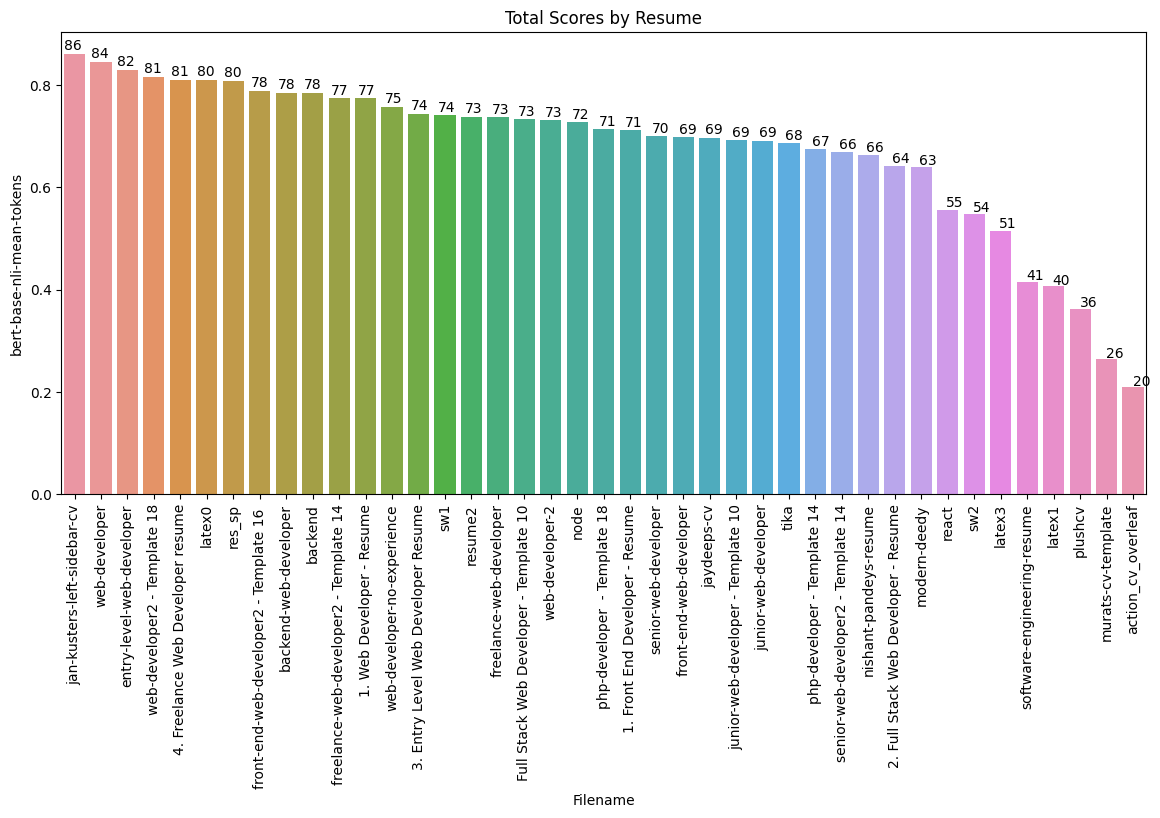

In [19]:
def visualize_scores(df):
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x="Filename", y="bert-base-nli-mean-tokens", data=df.sort_values(by='bert-base-nli-mean-tokens', ascending=False)[:-2])
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()*100)}', (p.get_x()*1.01, p.get_height()*1.01))
    plt.xticks(rotation=90)
    plt.title("Total Scores by Resume")
    plt.show()

visualize_scores(df_resume)